In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

In [3]:
from src.accounts import Four01k, IRA
from src.allocations import custom_allocation, get_vanguard_glide_path
from src.computations import run_simulations
from src.inputs import ParametricOptimizationInputs, HistoricalInputs
from src.plots import plot_ending_balance_hist, plot_time_series, plot_single_time_series
from src.retiree import Retiree, make_ret_df

In [4]:
#### Make Person ########
retiree = Retiree(
    age=50,
    year=2048,
    current_income=200_000,
    min_net_income=70_000,
    desired_retirement_income=100_000,
    effective_tax_rate=0.33,
    raise_rate=0.03,
)

####### Make Accounts ######
retiree_401k = Four01k(retiree=retiree)

retiree_ira = IRA(retiree=retiree)

retiree_df = make_ret_df(
    ret=retiree,
    ret_401k=retiree_401k,
    ret_ira=retiree_ira,
    starting_roth_401k=300_000,
    starting_trad_ira=100_000,
    starting_trad_match_401k=100_000,
)

retiree_df.loc[retiree.age:].head(15)

,year,age,earnings,net_earnings,r_401k_dep,t_401k_dep,t_401k_match_dep,r_ira_dep,t_ira_dep,total_roth_dep,total_trad_dep,ssi_income,with
50,2048,50,200000.00,106082.27,300000.0,30000.0,106000.00,0.0,107500.0,300000.0,243500.00,0.0,0.0
51,2049,51,206000.00,109947.71,0.0,30000.0,6180.00,0.0,7500.0,0.0,43680.00,0.0,0.0
52,2050,52,212180.00,113929.11,0.0,30000.0,6365.40,0.0,7500.0,0.0,43865.40,0.0,0.0
53,2051,53,218545.40,118029.96,0.0,30000.0,6556.36,0.0,7500.0,0.0,44056.36,0.0,0.0
54,2052,54,225101.76,121885.70,0.0,30000.0,6753.05,0.0,7500.0,0.0,44253.05,0.0,0.0
55,2053,55,231854.81,125696.03,0.0,30000.0,6955.64,0.0,7500.0,0.0,44455.64,0.0,0.0
56,2054,56,238810.46,129620.68,0.0,30000.0,7164.31,0.0,7500.0,0.0,44664.31,0.0,0.0
57,2055,57,245974.77,133663.07,0.0,30000.0,7379.24,0.0,7500.0,0.0,44879.24,0.0,0.0
58,2056,58,253354.02,137800.61,0.0,30000.0,7600.62,0.0,7500.0,0.0,45100.62,0.0,0.0
59,2057,59,260954.64,142020.33,0.0,30000.0,7828.64,0.0,7500.0,0.0,45328.64,0.0,0.0


In [5]:
#### Make Allocation Strategies ####
allocation_strats={
    'Target Date 2040\nVanguard Default': get_vanguard_glide_path(default=True, max_age=retiree.life_expectancy),
    'Target Date 2030\nVanguard Default': np.concatenate((
        get_vanguard_glide_path(default=True, max_age=retiree.life_expectancy)[:10],
        get_vanguard_glide_path(default=True, max_age=retiree.life_expectancy)[:-10])),
    '75/25 for life': custom_allocation(
        max_age=retiree.life_expectancy,
        inflection_points=[0,1],
        stock_pcts=[0.75, 0.75]),
}

Done. 270 simulations of 50 years took 0.12s


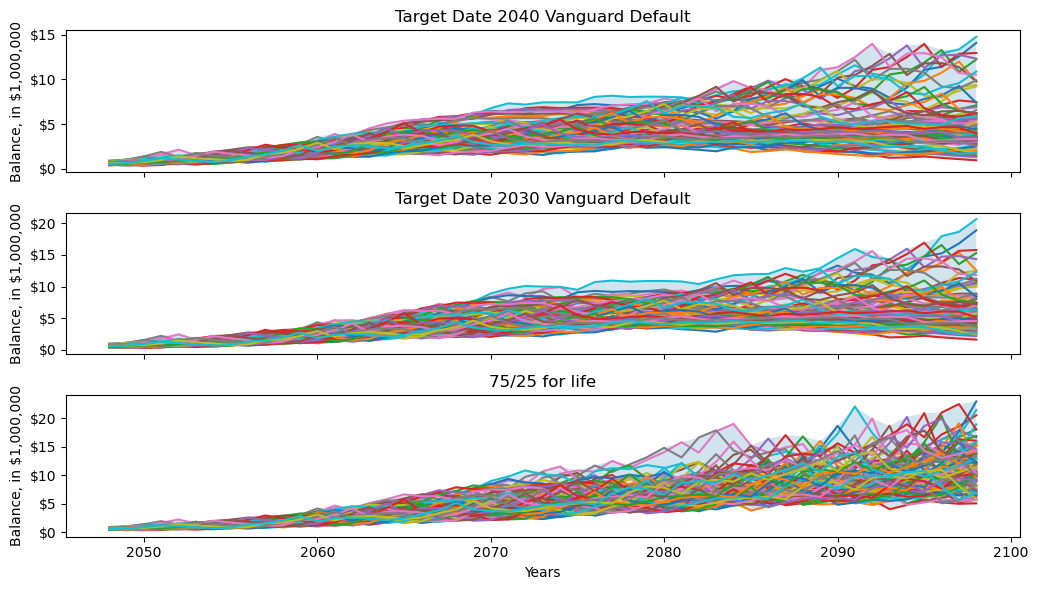

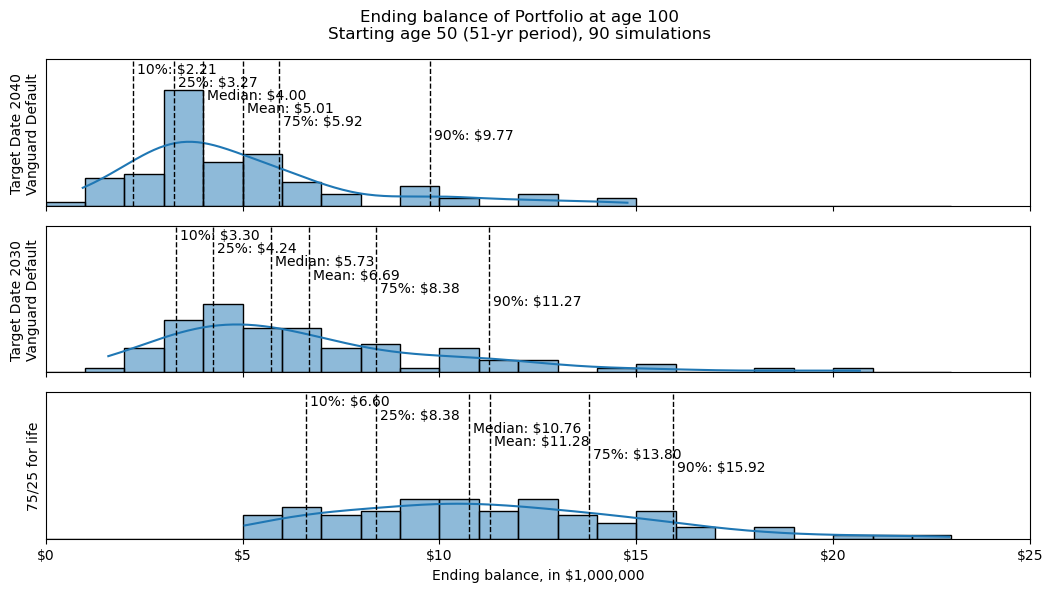

In [6]:
historical = HistoricalInputs(sheetname='ibbotson', start_year=1926, cycle=True)
start_age = retiree.age
end_age = 100
N_SIMS = historical.get_n_sims(end_age - start_age + 1)
historical_results = run_simulations(
    ret=retiree,
    ret_df=retiree_df,
    allocation_strats=allocation_strats,
    rng=historical,
    start_age=start_age,
    end_age=end_age,
    n_sims=N_SIMS)
fig, axs = plot_time_series(
    simulation_results=historical_results,
    years=retiree.years_arr[start_age:end_age+1]
)
fig.savefig('./data/HistoricalSimulationsPlot.png', dpi=500)
fig, axs = plot_ending_balance_hist(
    simulation_results={
        k: (historical_results[k]['traditional_balance'] + historical_results[k]['roth_balance'])[-1]
        for k in historical_results
    },
    n_sims=N_SIMS,
    start_age=start_age,
    end_age=end_age,
    xmax=25,
    bin_width=1,
    lines_to_show=['10%', '25%', 'Median', 'Mean', '75%', '90%']
)
fig.savefig('./data/HistoricalSimulationsHist.png', dpi=500)

Done. 270 simulations of 50 years took 0.16s


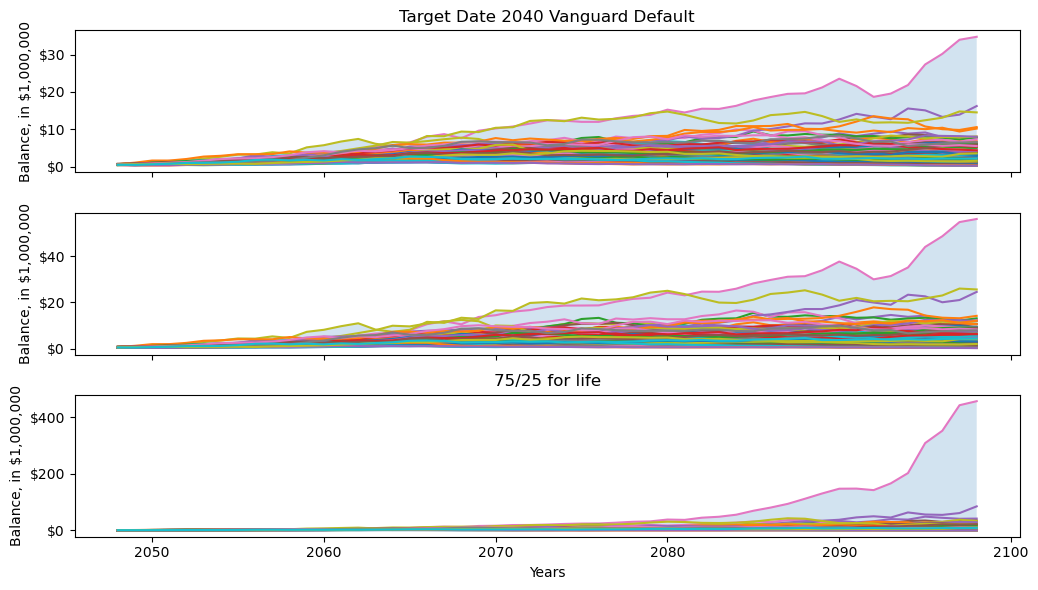

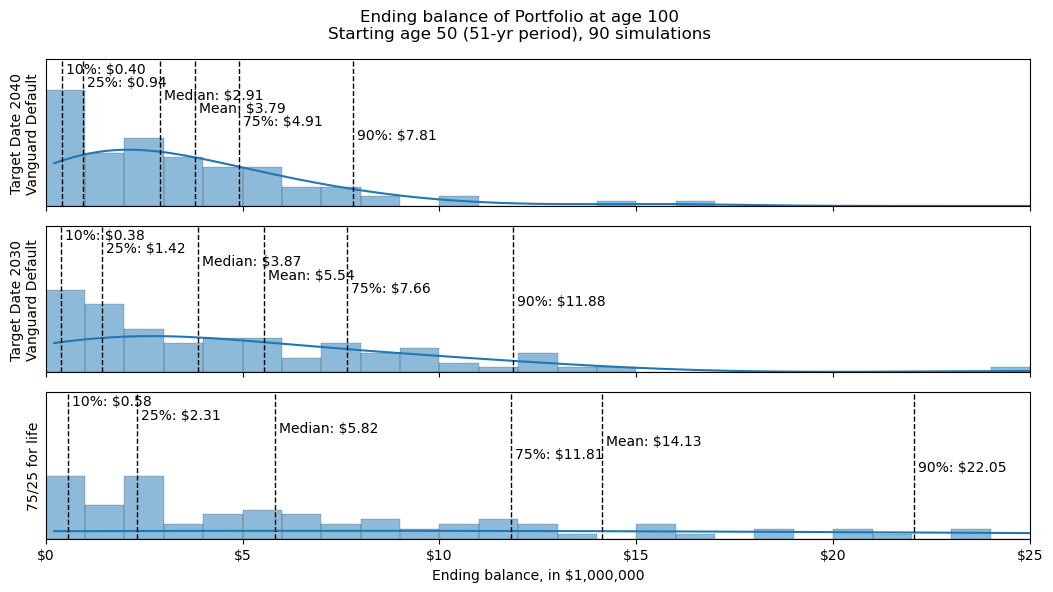

In [7]:
monte_carlo_results = run_simulations(
    ret=retiree,
    ret_df=retiree_df,
    allocation_strats=allocation_strats,
    rng=ParametricOptimizationInputs(seed=0),
    start_age=start_age,
    end_age=end_age,
    n_sims=N_SIMS)
fig, axs = plot_time_series(
    simulation_results=monte_carlo_results,
    years=retiree.years_arr[start_age:end_age + 1]
)
fig.savefig('./data/MonteCarloSimulationsPlot.png', dpi=500)
fig, axs = plot_ending_balance_hist(
    simulation_results={
        k: (monte_carlo_results[k]['traditional_balance'] + monte_carlo_results[k]['roth_balance'])[-1]
        for k in monte_carlo_results
    },
    n_sims=N_SIMS,
    start_age=start_age,
    end_age=end_age,
    xmax=25,
    bin_width=1,
    lines_to_show=['10%', '25%', 'Median', 'Mean', '75%', '90%']
)
fig.savefig('./data/MonteCarloSimulationsHist.png', dpi=500)